<a href="https://colab.research.google.com/github/baban9/Capstone-560/blob/main/Updated_Danielle_Keras_Binary_with_ROC_etc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

Mounted at /content/gdrive


In [2]:
data_dir = '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Images/'

print(os.listdir(data_dir))

['With UPC', 'Without UPC']


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


In [4]:
image_size = (600, 600)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1024 files belonging to 2 classes.
Using 820 files for training.
Found 1024 files belonging to 2 classes.
Using 204 files for validation.


In [6]:
data_augmentation = keras.Sequential(
    [
        # layers.experimental.preprocessing.RandomFlip("horizontal"),
        # layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.Resizing(128,128)
    ]
)


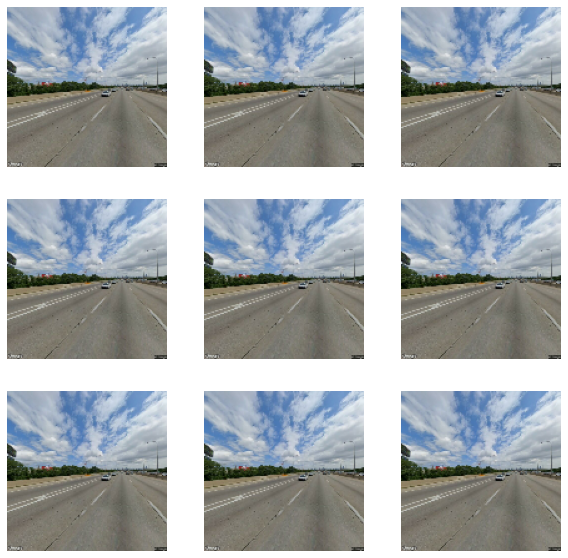

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [9]:
train_ds = train_ds.prefetch(buffer_size=5)
val_ds = val_ds.prefetch(buffer_size=5)


In [11]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)


In [12]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_Dan_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy",f1_m,precision_m, recall_m],   #can try another loss function type
)
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)


Epoch 1/50
103/103 [==============================] - 377s 3s/step - loss: 0.6602 - accuracy: 0.6826 - f1_m: 0.7830 - precision_m: 0.7538 - recall_m: 0.8450 - val_loss: 0.7113 - val_accuracy: 0.2402 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
103/103 [==============================] - 10s 90ms/step - loss: 0.5423 - accuracy: 0.7531 - f1_m: 0.8314 - precision_m: 0.7923 - recall_m: 0.9061 - val_loss: 0.7238 - val_accuracy: 0.2402 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
103/103 [==============================] - 10s 89ms/step - loss: 0.5194 - accuracy: 0.7747 - f1_m: 0.8316 - precision_m: 0.8128 - recall_m: 0.8835 - val_loss: 0.7171 - val_accuracy: 0.2451 - val_f1_m: 0.0128 - val_precision_m: 0.0385 - val_recall_m: 0.0077
Epoch 4/50
103/103 [==============================] - 10s 90ms/step - loss: 0.4557 - accuracy: 0.8024 - f1_m: 0.8554 - precision_m: 0.8259 - recall_m: 0.9066 - val_loss: 0.6

In [14]:
%ls

gdrive/            save_at_Dan_20.h5  save_at_Dan_32.h5  save_at_Dan_44.h5
sample_data/       save_at_Dan_21.h5  save_at_Dan_33.h5  save_at_Dan_45.h5
save_at_Dan_10.h5  save_at_Dan_22.h5  save_at_Dan_34.h5  save_at_Dan_46.h5
save_at_Dan_11.h5  save_at_Dan_23.h5  save_at_Dan_35.h5  save_at_Dan_47.h5
save_at_Dan_12.h5  save_at_Dan_24.h5  save_at_Dan_36.h5  save_at_Dan_48.h5
save_at_Dan_13.h5  save_at_Dan_25.h5  save_at_Dan_37.h5  save_at_Dan_49.h5
save_at_Dan_14.h5  save_at_Dan_26.h5  save_at_Dan_38.h5  save_at_Dan_4.h5
save_at_Dan_15.h5  save_at_Dan_27.h5  save_at_Dan_39.h5  save_at_Dan_50.h5
save_at_Dan_16.h5  save_at_Dan_28.h5  save_at_Dan_3.h5   save_at_Dan_5.h5
save_at_Dan_17.h5  save_at_Dan_29.h5  save_at_Dan_40.h5  save_at_Dan_6.h5
save_at_Dan_18.h5  save_at_Dan_2.h5   save_at_Dan_41.h5  save_at_Dan_7.h5
save_at_Dan_19.h5  save_at_Dan_30.h5  save_at_Dan_42.h5  save_at_Dan_8.h5
save_at_Dan_1.h5   save_at_Dan_31.h5  save_at_Dan_43.h5  save_at_Dan_9.h5


In [15]:
import numpy as np

path_model="./save_at_Dan_50.h5"
model.load_weights(path_model)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Images",
    seed=1337,
    image_size=image_size,
    batch_size=1,
)

count_test_samples = len(test_ds)
print("Count test data:", count_test_samples)


predict_prob = []
label_list = []
for i in range(count_test_samples):
    for image, label in test_ds.take(1):
        [[pred]] = model.predict(image)
        label_list.append(np.float32(label)[0])
        predict_prob.append(pred)
    # showing the test resluts
    if i == 8:
        print("predict_prob:", predict_prob)
        print("label_list:", label_list)
print("done!")

Found 1024 files belonging to 2 classes.
Count test data: 1024
predict_prob: [0.9999721, 1.0, 0.9995782, 4.3255386e-05, 0.9999968, 4.3255386e-05, 0.9999721, 0.9999721, 1.0]
label_list: [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
done!


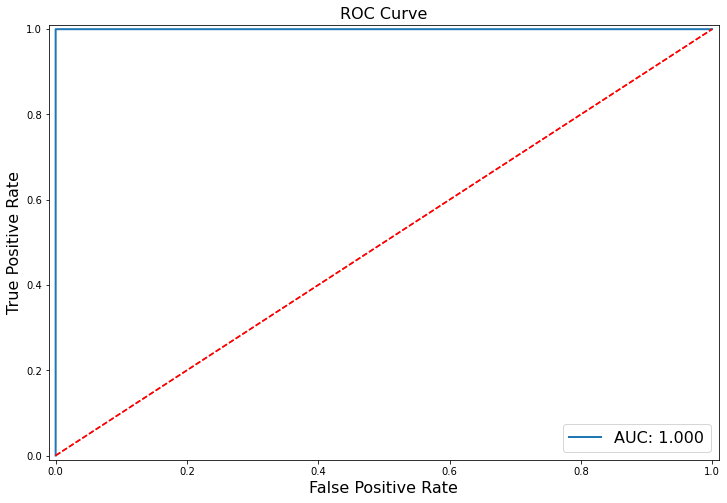

In [16]:
#ROC plots and similar
import matplotlib.pylab as plt

def get_roc(pred_prob,y_true):
    pos = y_true[y_true==1]
    neg = y_true[y_true==0]
    threshold = np.sort(pred_prob)[::-1]   
    y = y_true[pred_prob.argsort()[::-1]]
    tpr_all = [0] ; fpr_all = [0]
    tpr = 0 ; fpr = 0
    x_step = 1/float(len(neg))
    y_step = 1/float(len(pos))
    y_sum = 0                      
    for i in range(len(threshold)):
        if y[i] == 1:
            tpr += y_step
            tpr_all.append(tpr)
            fpr_all.append(fpr)
        else:
            fpr += x_step
            fpr_all.append(fpr)
            tpr_all.append(tpr)
            y_sum += tpr
    return tpr_all,fpr_all,y_sum*x_step


tpr_lr,fpr_lr,auc_lr = get_roc(np.array(predict_prob),np.array(label_list))  

plt.figure(figsize=(12,8))
plt.plot(fpr_lr,tpr_lr,label="AUC: {:.3f}".format(auc_lr),linewidth=2)
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,01.01])
plt.plot([(0,0),(1,1)],'r--')
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=16)
plt.show()


Text(0.5, 1.0, 'Precision Recall Curve')

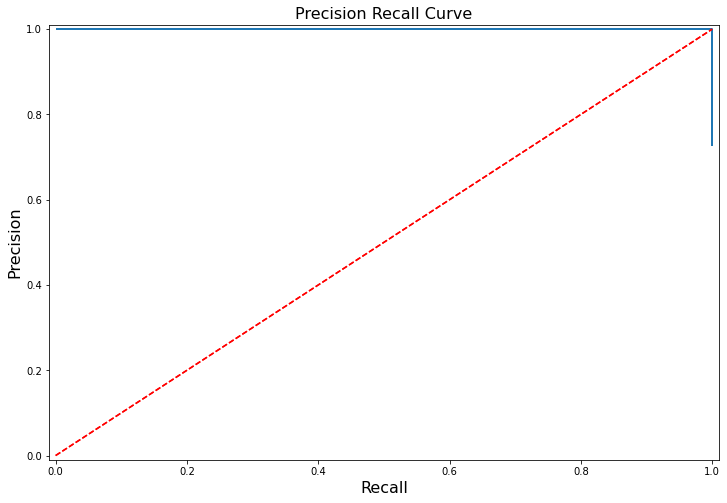

In [17]:
# PR curve
def get_pr(pred_prob,y_true):
    pos = y_true[y_true==1]
    threshold = np.sort(pred_prob)[::-1]
    y = y_true[pred_prob.argsort()[::-1]]
    recall = [] ; precision = []
    tp = 0 ; fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
            auc += (recall[i]-recall[i-1])*precision[i]
        else:
            fp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
    return precision,recall,auc

precision_lr,recall_lr,auc_lr = get_pr(np.array(predict_prob),np.array(label_list))

plt.figure(figsize=(12,8))
plt.plot(recall_lr,precision_lr,linewidth=2)
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,01.01])
plt.plot([(0,0),(1,1)],'r--')
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.title("Precision Recall Curve",fontsize=16)


In [18]:
# confuse matrix
def get_conf_mat(pred_prob,y_true):
    TP,FP,FN,TN = 0,0,0,0
    num_label = pred_prob.shape[0]
    for i in range (num_label):
        if y_true[i] == 1 and pred_prob[i] > 0.5:
            TP += 1
        elif y_true[i] == 1 and pred_prob[i] < 0.5:
            FN += 1
        elif y_true[i] == 0 and pred_prob[i] < 0.5:
            TN += 1
        else:
            FP += 1

    return TP,FP,FN,TN

        
TP,FP,FN,TN = get_conf_mat(np.array(predict_prob),np.array(label_list))
conf_mat = [[TP,FP],[FN,TN]]
print("confuse_matrix:", conf_mat)

confuse_matrix: [[747, 0], [0, 277]]
